In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

In [3]:
mask_path = '../data/'
frames_path = '../data/frames/C59_L1_t0'

In [4]:
angle_increment = 1
min_angle = 0
max_angle = 90

In [5]:
img_orig = cv2.imread(os.path.join(frames_path,'frame-500.jpg'),0)
img_mask = cv2.imread(os.path.join(mask_path,'mask-1-cropped.jpg'),0)

In [6]:
#print(img_mask.shape)

#scale_percent = 60 # percent of original size
#width = int(img_mask.shape[1] * scale_percent / 100)
#height = int(img_mask.shape[0] * scale_percent / 100)
#dim = (width, height)
# resize image
#img_mask = cv2.resize(img_mask, dim, interpolation = cv2.INTER_AREA)

#print(img_mask.shape)

In [7]:
img_blur = cv2.medianBlur(img_orig,7)
img_thresh = cv2.adaptiveThreshold(img_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
img_thresh_inv = cv2.bitwise_not(img_thresh)
ret, img_mask = cv2.threshold(img_mask, 10, 255, cv2.THRESH_BINARY)

In [8]:
angle = min_angle
images = []
scores = []
positions = []

rows,cols = img_orig.shape
print("Main image has {0} rows and {1} cols".format(rows,cols))

while angle <= max_angle:
    
    # Rotate mask and log
    img_mask_rotated = rotate_bound(img_mask, angle)
    ret, img_mask_rotated = cv2.threshold(img_mask_rotated, 1, 255, cv2.THRESH_BINARY)
    mask_rows,mask_cols = img_mask_rotated.shape
    print("Current rotation {2} degrees has {0} rows and {1} cols".format(mask_rows,mask_cols,angle))
    
    # Pass image over
    for i in range(rows):
        if i + mask_rows > rows:
            continue
        for j in range(cols):
            if j + mask_cols > cols:
                continue
            
            # Create roi
            roi = img_thresh_inv[i:mask_rows+i,j:mask_cols+j]
            
            #print(img_mask_rotated.shape)
            #print(roi.shape)
            #print([i,j,angle])
            
            # Mask with mask
            masked = cv2.bitwise_and(roi,img_mask_rotated)
            
            # Save image and scores
            images.append(masked)
            scores.append(masked.sum())
            positions.append([i,j,angle])
            
    angle += angle_increment
            
print("Complete")
    
#plot_count = len(images)
#for i in range(plot_count):
#    plt.figure(figsize=(100,100))
#    plt.subplot(plot_count,1,i+1),plt.imshow(images[i],'gray')
#    plt.title(scores[i])
#    plt.xticks([]),plt.yticks([])
#    plt.show()

Main image has 128 rows and 128 cols
Current rotation 0 degrees has 15 rows and 65 cols
Current rotation 1 degrees has 16 rows and 65 cols
Current rotation 2 degrees has 17 rows and 65 cols
Current rotation 3 degrees has 18 rows and 65 cols
Current rotation 4 degrees has 19 rows and 65 cols
Current rotation 5 degrees has 20 rows and 66 cols
Current rotation 6 degrees has 21 rows and 66 cols
Current rotation 7 degrees has 22 rows and 66 cols
Current rotation 8 degrees has 23 rows and 66 cols
Current rotation 9 degrees has 24 rows and 66 cols
Current rotation 10 degrees has 26 rows and 66 cols
Current rotation 11 degrees has 27 rows and 66 cols
Current rotation 12 degrees has 28 rows and 66 cols
Current rotation 13 degrees has 29 rows and 66 cols
Current rotation 14 degrees has 30 rows and 66 cols
Current rotation 15 degrees has 31 rows and 66 cols
Current rotation 16 degrees has 32 rows and 66 cols
Current rotation 17 degrees has 33 rows and 66 cols
Current rotation 18 degrees has 34 ro

Numer of images scored:  544679
Max score:  93585
Max index:  233488
Position of max score:  [18, 40, 38]


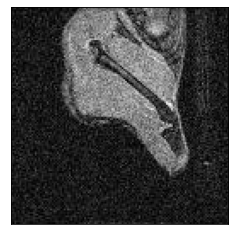

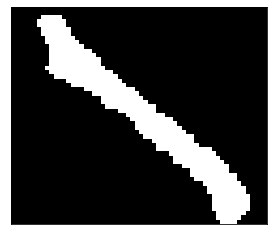

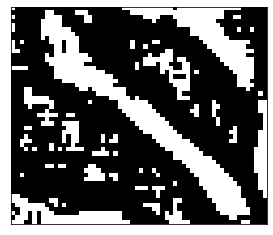

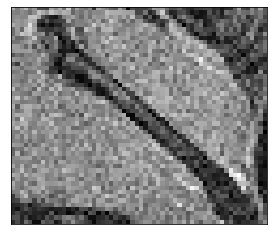

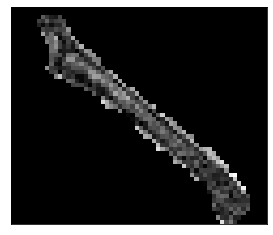

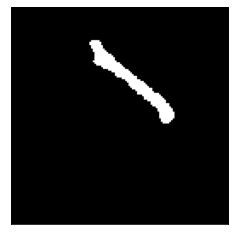

In [9]:
max_score = np.max(scores)
max_index = np.argmax(scores)
best_position = positions[max_index]

print("Numer of images scored: ", str(len(images)))
print("Max score: ", str(max_score))
print("Max index: ", str(max_index))
print("Position of max score: ", best_position)

# Create rois
img_mask_rotated = rotate_bound(img_mask, best_position[2])
ret, img_mask_rotated = cv2.threshold(img_mask_rotated, 1, 255, cv2.THRESH_BINARY)
mask_rows,mask_cols = img_mask_rotated.shape

#print(img_mask_rotated.shape)
#print(img_orig.shape)

roi1 = img_orig[best_position[0]:mask_rows+best_position[0],best_position[1]:mask_cols+best_position[1]]
roi2 = img_thresh_inv[best_position[0]:mask_rows+best_position[0],best_position[1]:mask_cols+best_position[1]]

#print(img_mask_rotated.shape)
#print(roi1.shape)
#print(roi2.shape)

masked = cv2.bitwise_and(roi1,img_mask_rotated)

# Get mask in broader image
final_mask = np.zeros(img_orig.shape)
final_mask[best_position[0]:mask_rows+best_position[0],best_position[1]:mask_cols+best_position[1]] = img_mask_rotated

plt.figure()
plt.xticks([]),plt.yticks([])
plt.imshow(img_orig,'gray')
plt.show()

plt.figure()
plt.xticks([]),plt.yticks([])
plt.imshow(img_mask_rotated,'gray')
plt.show()

plt.figure()
plt.xticks([]),plt.yticks([])
plt.imshow(roi2,'gray')
plt.show()

plt.figure()
plt.xticks([]),plt.yticks([])
plt.imshow(roi1,'gray')
plt.show()

plt.figure()
plt.xticks([]),plt.yticks([])
plt.imshow(masked,'gray')
plt.show()

plt.figure()
plt.xticks([]),plt.yticks([])
plt.imshow(final_mask,'gray')
plt.show()